# DNS Traffic Classification and Model Drift Detection

This project implements a machine learning classifier to identify malicious DNS traffic for cybersecurity applications. DNS requests consist of human-readable text (e.g., google.com) sent to a DNS server to resolve IP addresses. Adversaries exploit this protocol by encoding exfiltrated data in DNS requests sent to adversary-controlled DNS servers. Malicious DNS traffic exhibits different characteristics from normal DNS traffic due to this data encoding behavior.

The analysis uses 1 training dataset CSV file, 10 production dataset CSV files (one per weekday from 06-02-2025 to 06-13-2025), an encrypted training data provenance file, a cipher key, and a hash of the training data. Note: in production, encrypted datasets should not be stored alongside plaintext cipher keys.

The data used in this analysis are derived from https://data.mendeley.com/datasets/c4n7fckkz3/3, DOI:10.17632/c4n7fckkz3.3.

## Data Loading

Load all dataset files into the working directory.

In [3]:
# Package Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random
from sklearn.metrics import accuracy_score
from cryptography.fernet import Fernet
import io
import hashlib
import matplotlib.pyplot as plt
import math
from statsmodels.stats.proportion import proportion_confint


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Load all dataset CSV files.

In [4]:
# Read in the data sets
train_df = pd.read_csv("train_df.csv")
day1 = pd.read_csv("day1.csv")
day2 = pd.read_csv("day2.csv")
day3 = pd.read_csv("day3.csv")
day4 = pd.read_csv("day4.csv")
day5 = pd.read_csv("day5.csv")
day6 = pd.read_csv("day6.csv")
day7 = pd.read_csv("day7.csv")
day8 = pd.read_csv("day8.csv")
day9 = pd.read_csv("day9.csv")
day10 = pd.read_csv("day10.csv")


## Decryption

Decrypt the data provenance file to verify dataset metadata and integrity.

In [ ]:
# Read in the encrypted data provenance csv file.
# The Fernet cipher was used for encryption
# Reference: https://www.geeksforgeeks.org/python/fernet-symmetric-encryption-using-cryptography-module-in-python/

# Read in the encrypted CSV
with open("Data_provenance_encrypted.csv", "rb") as f:
    encrypted_csv = f.read()
print("The encrypted file looks like: \n",encrypted_csv)


# Next, decrypt the csv
with open("cipher_key.txt", "rb") as kf:
    key = kf.read()

cipher = Fernet(key)
decrypted_csv = cipher.decrypt(encrypted_csv)

# Convert to pandas DataFrame and print
Data_provenance_df = pd.read_csv(io.StringIO(decrypted_csv.decode()))
print("\n\n The unencrypted file looks like: \n",Data_provenance_df)

The encrypted file looks like: 
 b'gAAAAABpC4Wwlau1yBg8UXkB2CBO1Uuk_Gul4AXp-NH-M0nuDwGcQ_8v2AtbsP7P2Vdjqt-J-6pUdlnuInpxZChzpkk3Ir1PMCS3hY9FfWarKAjXt9AuRRuUrjpmh0zmAnFN1-ZinB0-OI_ZGtJnWodCd3igTd7EoiOrjGCGzpClsCOh_cHH50gYee0PggGeCM53fXDDem9JQ1nNff9UFf0JJFF1s_XJiInbbKT11r1YAZdtJagP6cqi6zmbn8uI6QDgSBjJuWxKIoN_dgIW2pqtE1wbpXgOg1J_KDx5DPZrTcyNKZER7TWcAewYir4Ne4rEkYZFQnCgYvefL0fE9cRqpP1ybWk6UrEpj06cXUTysuoPtE2v_aE2S-jq3W9kp8eqUx5qCvXY1iegpnGW1Dij3rPq6ea06KoXlSdgkX-wOubb920LB1mJUDDXnON9Kjt7wqLNDhVh1LYsfG2Zl4aXvfQpd3mCoW4Tfd9JBUW2biTjtEDnQ2F6s7XM8POlaLYFms7lrBspIcAPGedjE9v55DpDpMHjqM32Pm08JZ_GR_0tZJ903jjdE50nYyOuMsDxEw75vsify7777Mov_A1DQ2HShA6I1gRB7d4hHqdGx3RrzPZWXNkgmexrgcMDtyPLhVQPCWw5u7yUrZND5RtCMgp4_5dwEBidQn2E7czsZ5w3cYjSewAAq2hLZ6g4REUASpcpomd-3UKV8V3HZFxJkIQgscL8-BrcqErHQIW9mAbKJGJKpvHfyWevq1C1d3mnx5WGVsjQrX6w-20mvMzwm3_9NmTPQbJVco_EXeUzO3NE0RWpm-HbWBpBPauEFQXHg4tOwoaKP3juJANUpdbLS4pmJA6Af-XDgDETFNnx2amwgRZWN4w7UQ3WOEIJLPQ-R8EkevtNv3UCwnrMhHTcIa3CEZEYHhQ3Z-y1-2xotm3LK9crxi33CDuQPQu1QNKO4

## Encryption

Encrypt the training data to protect sensitive datasets from unauthorized access. 

In [ ]:
# Encryption

# Encrypt train_df to protect it from adversaries
# Use the Fernet cipher
# Note: In production, store the cipher key in a separate, secure location (e.g., key management service)

cipher = Fernet(Fernet.generate_key())

# Convert DataFrame to CSV bytes
csv_bytes = train_df.to_csv(index=False).encode()

# Encrypt the CSV bytes
encrypted_csv = cipher.encrypt(csv_bytes)

# Save the encrypted csv bytes to a file
with open("train_df_encrypted.csv", "wb") as f:
    f.write(encrypted_csv)

# Print cipher key (for demonstration; in production, store securely)
print(cipher._signing_key + cipher._encryption_key)

b"d\x13n\xe8IH81\xc3E\xae\xa1W\xab\xf8\xdd4ilm$\xde'`\x97\x97\x19\xaa\xd0~\xec\xfe"


## Data Provenance

Inspect the decrypted data provenance file to verify dataset metadata, creation dates, and associated ML models match expected values.

In [ ]:
# Inspect the decrypted data provenance DataFrame
print(Data_provenance_df.head())
print("\nSummary info:\n")
print(Data_provenance_df.info())

  Dataset_name      Creator Date_modified        Originating_source  \
0         day1  Roosa Katia    06-02-2025  DOI10.17632/c4n7fckkz3.3   
1         day2  Roosa Katia    06-03-2025  DOI10.17632/c4n7fckkz3.3   
2         day3  Roosa Katia    06-04-2025  DOI10.17632/c4n7fckkz3.3   
3         day4  Roosa Katia    06-05-2025  DOI10.17632/c4n7fckkz3.3   
4         day5  Roosa Katia    06-06-2025  DOI10.17632/c4n7fckkz3.3   

  Associated_ML_models  
0   DNS_Exfil_Detector  
1   DNS_Exfil_Detector  
2   DNS_Exfil_Detector  
3   DNS_Exfil_Detector  
4   DNS_Exfil_Detector  

Summary info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Dataset_name          10 non-null     object
 1   Creator               10 non-null     object
 2   Date_modified         10 non-null     object
 3   Originating_source    10 non-null     object
 4   A

## Data Integrity Verification

Use cryptographic hashing to verify that the training data has not been modified. The implementation demonstrates that any modification to the dataset is detected by the hashing algorithm.

In [ ]:
# Verify the training data has not been modified

# Any change, even seemingly insignificant, to a dataset will modify the hash
# Replicate the pre-sorting done to the original dataset for consistent hashing
def stable_hash_df(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=df.columns.tolist()).reset_index(drop=True)
    df_str = df_sorted.applymap(lambda x: f"{x:.12g}" if isinstance(x, float) else str(x))
    return hashlib.sha256(pd.util.hash_pandas_object(df_str, index=False).values).hexdigest()

# Read in or paste hash 
saved_hash = saved_hash = open("train_df_hash.txt", "r").read().strip()



# Compare hashes
def compare_hashes(df):
    current_hash = stable_hash_df(df)
    if current_hash == saved_hash:
        print("inputted df has not been modified.")
    else:
        print("inputted df has been modified!")

compare_hashes(train_df)

# test that making a change to one entry will modify the hash
print("\n\n\nPre-flip--Attack?: ",train_df.loc[10,"attack"])
print("Flipping label...\n\n")

### Flip the label of "attack" for train_df row 10##
train_df.loc[10, "attack"] = 1 - train_df.loc[10, "attack"]

print("\n\n\nPost-flip--Attack?: ",train_df.loc[10,"attack"])

compare_hashes(train_df)
print("Unflipping label...\n\n")

### Unflip the label of "attack" for train_df row 10##
train_df.loc[10, "attack"] = 1 - train_df.loc[10, "attack"]

print("\n\n\nAttack?: ",train_df.loc[10,"attack"])
compare_hashes(train_df)




inputted df has not been modified.



Pre-flip--Attack?:  0
Flipping label...





Post-flip--Attack?:  1
inputted df has been modified!
Unflipping label...





Attack?:  0
inputted df has not been modified.


## Feature Engineering

Prepare features and labels for model training.

In [9]:
# Prepare data for model training

# the features we will train the model on
feature_columns = ["request_length", "subdomain_count", "entropy", "digits_ratio","word_count","word_max_length","word_max_ratio","uppercase_ratio"]
# the label column
label_column = "attack"

# scaling the features
feature_scaler = StandardScaler()
feature_scaler.fit(train_df[feature_columns])

# encoding the label
label_encoder = LabelEncoder()
label_encoder.fit(train_df[label_column])

LabelEncoder()

## Model Training

Train a random forest classifier to distinguish between benign and malicious DNS requests.

In [10]:
# Train a random forest model

trained_model = RandomForestClassifier(
    n_estimators= 100,
    max_depth= 5,
    min_samples_split= 5,
    min_samples_leaf= 5,
    class_weight="balanced")

trained_model.fit(train_df[feature_columns],
                  train_df[label_column])

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Model Monitoring

Monitor model performance in production. Each day DataFrame (e.g., day1) represents one day's worth of production DNS traffic.

Calculate model accuracy for each production day.

In [11]:
# Test model on each production day of data

# this vector will store the accuracy of the model on each day
accuracy_by_day = []

# this code loops through each day of data
# it calculates the model's prediction for every DNS request whether it is an attack or benign
# it summarizes these data by calculating the accuracy of the model by day

for i, df in enumerate([day1, day2, day3, day4, day5, day6, day7, day8, day9, day10], start=1):
    # transforming the production data based on our scaler from before
    df[feature_columns] = feature_scaler.transform(df[feature_columns])

    # encoding based on our encoder from before
    df[label_column] = label_encoder.transform(df[label_column])

    # predicting the labels in the production data
    predictions = trained_model.predict(df[feature_columns])

    # store the accuracy for use outside the loop
    accuracy_by_day.append(accuracy_score(df['attack'], predictions))

    print(f"Accuracy on Day {i}: {accuracy_score(df['attack'], predictions)}")




Accuracy on Day 1: 0.9969473684210526
Accuracy on Day 2: 0.995578947368421
Accuracy on Day 3: 0.9970526315789474
Accuracy on Day 4: 0.9963157894736843
Accuracy on Day 5: 0.9974736842105263
Accuracy on Day 6: 0.9949473684210526
Accuracy on Day 7: 0.9963157894736843
Accuracy on Day 8: 0.9061
Accuracy on Day 9: 0.9052
Accuracy on Day 10: 0.9076


Calculate recall for the malicious (attack=True) class to assess detection performance.

In [12]:
# This code is the same but calculates the recall in the attack=True group
# recall is the percent of attack=True data that were correctly labeled as attacks 
recall_by_day = []

for i, df in enumerate([day1, day2, day3, day4, day5, day6, day7, day8, day9, day10], start=1):
    df[feature_columns] = feature_scaler.transform(df[feature_columns])
    df[label_column] = label_encoder.transform(df[label_column])
    predictions = trained_model.predict(df[feature_columns])
    attack_recall = accuracy_score(df[df['attack'] == 1]['attack'], 
                                     predictions[df['attack'] == 1])
    print(f"Attack recall on Day {i}: {attack_recall}")


Attack recall on Day 1: 0.99
Attack recall on Day 2: 0.982
Attack recall on Day 3: 0.986
Attack recall on Day 4: 0.986
Attack recall on Day 5: 0.982
Attack recall on Day 6: 0.986
Attack recall on Day 7: 0.988
Attack recall on Day 8: 0.093
Attack recall on Day 9: 0.087
Attack recall on Day 10: 0.098


## Performance Visualization

Plot model accuracy over time to identify performance degradation and potential data drift.

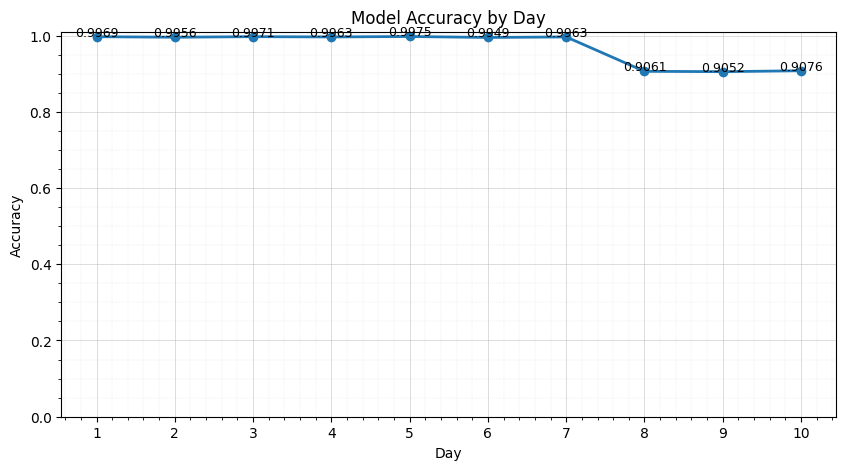

In [ ]:
# Plot the model accuracy against time in days

days = list(range(1, len(accuracy_by_day) + 1))

plt.figure(figsize=(10, 5))

# Plot accuracy line
plt.plot(days, accuracy_by_day, marker="o", linewidth=2, label="Daily Accuracy")

# Add numeric labels above each point
for x, y in zip(days, accuracy_by_day):
    plt.text(x, y + 0.002, f"{y:.4f}", ha="center", fontsize=9)

# Axis labels and title
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Day")

# Improve granularity
plt.xticks(days)
plt.ylim(0, 1.01)

# Add minor ticks + detailed grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.6)
plt.grid(which='minor', linestyle='--', linewidth=0.3, alpha=0.3)



## Drift Detection

Implement a modified DDM (Drift Detection Method) drift detector to track model accuracy and detect when it deviates from expected performance on validation data.

Baseline: model accuracy of 0.9967 on a held-out test set (validation data not used for model fitting).

In [ ]:
# Monitor whether the model accuracy is within expected bounds
# p_hat is the model accuracy on a validation dataset (not training data, as the model will perform overly well on data it was trained on)
p_hat = 0.9967
n = 10000
k= p_hat * n

# 95% confidence interval using Wilson method.
# The Wilson method is okay when p is near 0 or 1.
ci_low, ci_high = proportion_confint(count=k, nobs=n, alpha=0.05, method='wilson')


print(f"Observed p-hat: {p_hat:.10f}")
print(f"95% confidence interval: ({ci_low:.10f}, {ci_high:.10f})")

Observed p-hat: 0.9967000000
95% confidence interval: (0.9953693594, 0.9976491766)


## Drift Detection Visualization

Add confidence interval alarm thresholds to the accuracy plot to visualize when model performance falls outside acceptable bounds.

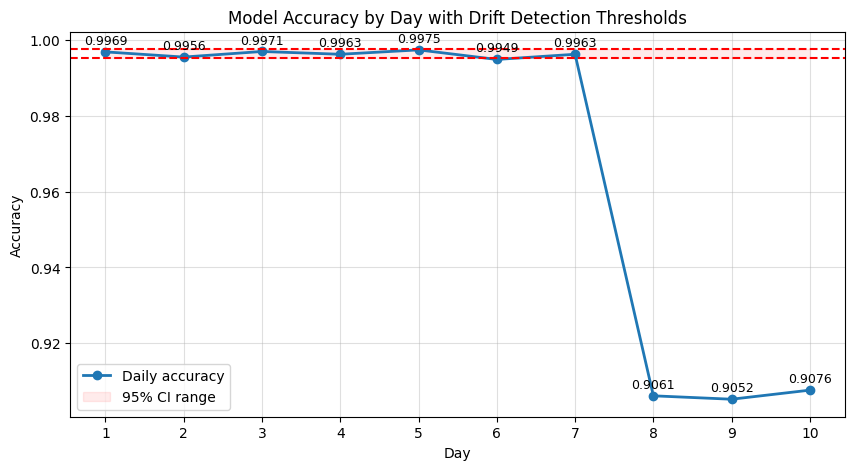

In [ ]:
# Add confidence interval alarm thresholds to the accuracy plot
# ci_low and ci_high define the bounds for acceptable deviation from the calibrated p_hat

plt.figure(figsize=(10, 5))

plt.plot(days, accuracy_by_day, marker="o", linewidth=2, label="Daily accuracy")

# Shaded CI region
plt.fill_between(days, ci_low, ci_high, color="red", alpha=0.08, label="95% CI range")

# Add CI lines
plt.axhline(ci_low, linestyle="--", color="red")
plt.axhline(ci_high, linestyle="--", color="red")

# Labels
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Day with Drift Detection Thresholds")
plt.xticks(days)

# Text labels for each point
for x, y in zip(days, accuracy_by_day):
    plt.text(x, y + 0.002, f"{y:.4f}", ha="center", fontsize=9)

plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

## Model Retraining

Retrain the model using production data from day 8 to adapt to the observed data distribution shift.

In [18]:
# Model retraining on day8 data set (rather than train_df)

trained_model.fit(day8[feature_columns],
                  day8[label_column])

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,5
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Evaluate the retrained model's accuracy on day 9 and day 10 production data.

In [19]:
# Calculating the accuracy of the newly trained model on day9 and day10 data

accuracy_by_day = []

for i, df in enumerate([day9, day10], start=1):
    df[feature_columns] = feature_scaler.transform(df[feature_columns])
    df[label_column] = label_encoder.transform(df[label_column])
    predictions = trained_model.predict(df[feature_columns])
    accuracy_by_day.append(accuracy_score(df['attack'], predictions))
    print(f"Accuracy on Day {i}: {accuracy_score(df['attack'], predictions)}")


Accuracy on Day 1: 0.9095
Accuracy on Day 2: 0.9089


Calculate recall for the retrained model on day 9 and day 10 production data.

In [20]:
# Calculating the recall of the newly trained model on day9 and day10 data

# Test model on each production day of data
recall_by_day = []

for i, df in enumerate([day9, day10], start=1):
    df[feature_columns] = feature_scaler.transform(df[feature_columns])
    df[label_column] = label_encoder.transform(df[label_column])
    predictions = trained_model.predict(df[feature_columns])
    attack_recall = accuracy_score(df[df['attack'] == 1]['attack'], 
                                     predictions[df['attack'] == 1])
    print(f"Attack recall on Day {i}: {attack_recall}")


Attack recall on Day 1: 0.987
Attack recall on Day 2: 0.994
